# IMPORT  THE NECESSARY PACKAGES

In [1]:
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt
import dlib
import cv2

# EXTRACT EYES LANDMARKS WITH DLIB

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(".\\dlib_shape_predictor\\shape_predictor_68_face_landmarks.dat")

In [3]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [4]:
print(f"Right eye indices: from {rStart} to {rEnd}")
print(f"Left eye indices: from {lStart} to {lEnd}")

Right eye indices: from 36 to 42
Left eye indices: from 42 to 48


In [5]:
def extract_eyes_landmarks(landmarks,rStart,rEnd,lStart,lEnd):
    shape = face_utils.shape_to_np(landmarks)
    rightEye = shape[rStart:rEnd]
    leftEye = shape[lStart:lEnd]
    return rightEye,leftEye

In [6]:
def draw_eyes_landmarks(image):
    
    faces= detector(image)
    for face in faces:
        landmarks = predictor(image, face)
        #(bX, bY, bW, bH) = face_utils.rect_to_bb(face)
        #cv2.rectangle(image, (bX, bY), (bX + bW, bY + bH), (0, 255, 0), 1)
        for i in range(rStart, lEnd):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  
        rightEye,leftEye=extract_eyes_landmarks(landmarks,rStart,rEnd,lStart,lEnd)
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(image, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(image, [rightEyeHull], -1, (0, 255, 0), 1)
        return image,rightEye,leftEye

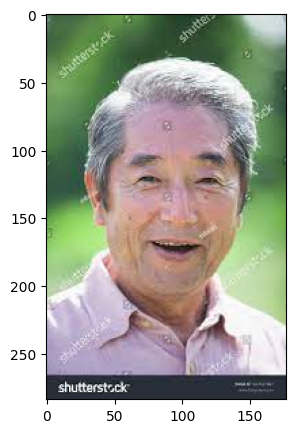

In [7]:
plt.figure(figsize=(15,5))
test_img=cv2.imread("picpic.jpg")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

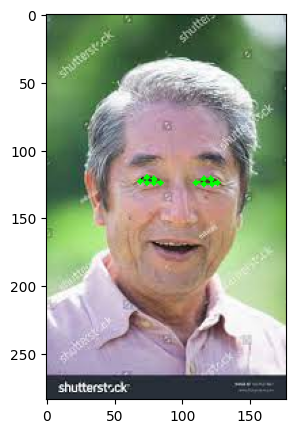

In [8]:
plt.figure(figsize=(15,5))
test_img,rightEye,leftEye=draw_eyes_landmarks(test_img)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

# Eye Aspect Ratio (EAR) function

In [9]:
# euclidean distance
def euclidean_dist(ptA, ptB):
	return np.linalg.norm(ptA - ptB)
# EAR 
def eye_aspect_ratio(eye):
	A = euclidean_dist(eye[1], eye[5])
	B = euclidean_dist(eye[2], eye[4])
	C = euclidean_dist(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [10]:
def compute_avg_EAR(righteye,lefteye):
    return round(((eye_aspect_ratio(righteye)+eye_aspect_ratio(lefteye))/2),3)

TEST

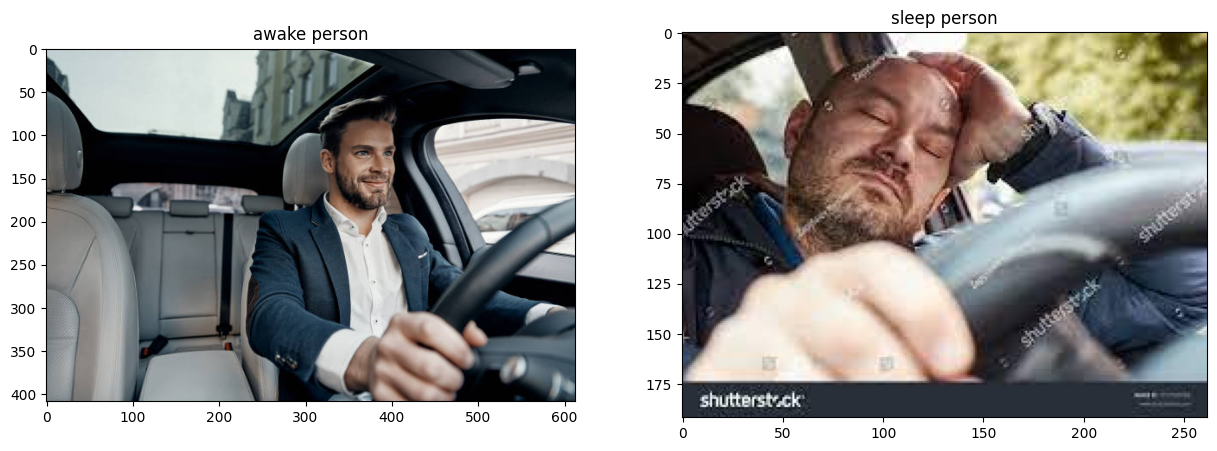

In [11]:
test_awake_img=cv2.imread(".\\images_test\\test_awake.jpg")
test_sleep_img=cv2.imread(".\\images_test\\sleep.jpg")
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(test_awake_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('awake person')
axs[1].imshow(cv2.cvtColor(test_sleep_img, cv2.COLOR_BGR2RGB))
axs[1].set_title('sleep person')
plt.show()

In [12]:
test_awake_img,rightEyeA,leftEyeA=draw_eyes_landmarks(test_awake_img)
test_sleep_img,rightEyeS,leftEyeS=draw_eyes_landmarks(test_sleep_img)
EAR_awake=compute_avg_EAR(rightEyeA,leftEyeA)
EAR_sleep=compute_avg_EAR(rightEyeS,leftEyeS)

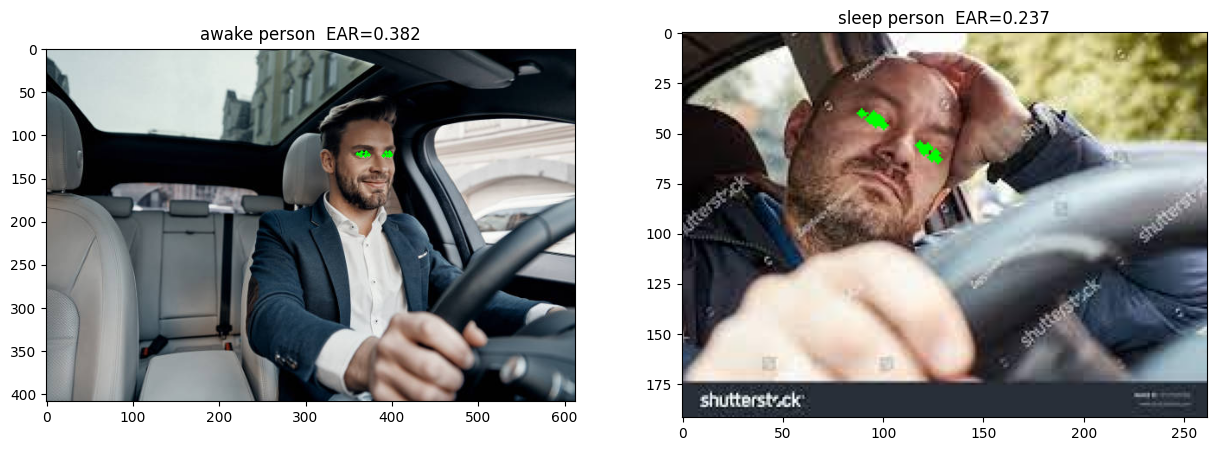

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(test_awake_img, cv2.COLOR_BGR2RGB))
axs[0].set_title(f'awake person  EAR={EAR_awake}')
axs[1].imshow(cv2.cvtColor(test_sleep_img, cv2.COLOR_BGR2RGB))
axs[1].set_title(f'sleep person  EAR={EAR_sleep}')
plt.show()

WebCam app

In [14]:
def calculate_fps(frame_count, start_time):
    end_time = cv2.getTickCount()
    elapsed_time = (end_time - start_time) / cv2.getTickFrequency()
    fps = frame_count / elapsed_time
    return fps

In [15]:
import pygame

def play_alert_sound():
    pygame.mixer.init()
    pygame.mixer.music.load("alert.mp3")  # Replace "alert_sound.wav" with the path to your sound file.
    pygame.mixer.music.play()

pygame 2.5.0 (SDL 2.28.0, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [16]:
def find_principal_face(faces):
    # If no faces are detected, return None
    if len(faces) == 0:
        return None

    # Find the largest face based on the bounding box area
    principal_face = max(faces, key=lambda face: (face.right() - face.left()) * (face.bottom() - face.top()))

    return principal_face

In [18]:
def eye_aspect_ratio_calibration(cap, detector, predictor, rStart, rEnd, lStart, lEnd):
    print("Eye Aspect Ratio Calibration")
    print("Please follow the instructions:")
    print("1. Keep your face still and look straight at the camera.")
    print("2. Close your eyes when prompted.")
    print("3. Open your eyes when prompted.")
    print("Press 'c' to start calibration.")

    closed_ear_history = []
    open_ear_history = []
    calibration_done = False
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        if len(faces) == 0:
            continue

        shape = predictor(gray, faces[0])
        rightEye, leftEye = extract_eyes_landmarks(shape, rStart, rEnd, lStart, lEnd)

        rightEAR = eye_aspect_ratio(rightEye)
        leftEAR = eye_aspect_ratio(leftEye)
        EAR = (rightEAR + leftEAR) / 2.0

        cv2.putText(frame, f"EAR: {EAR:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        cv2.imshow("EAR Calibration", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            print("Close your eyes now.")
            closed_ear_history.clear()
            while True:
                ret, frame = cap.read()
                frame = cv2.flip(frame, 1)
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces = detector(gray)

                if len(faces) == 0:
                    continue

                shape = predictor(gray, faces[0])
                rightEye, leftEye = extract_eyes_landmarks(shape, rStart, rEnd, lStart, lEnd)

                rightEAR = eye_aspect_ratio(rightEye)
                leftEAR = eye_aspect_ratio(leftEye)
                EAR = (rightEAR + leftEAR) / 2.0

                cv2.putText(frame, "CALIBRATING (Close Eyes)", (frame.shape[0]//2 - 140, frame.shape[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                cv2.imshow("EAR Calibration", frame)

                # Record EAR values during eye closure
                closed_ear_history.append(EAR)

                key = cv2.waitKey(1) & 0xFF
                if key == ord('o'):
                    print("Open your eyes now.")
                    open_ear_history.clear()
                    while True:
                        ret, frame = cap.read()
                        frame = cv2.flip(frame, 1)
                        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        faces = detector(gray)

                        if len(faces) == 0:
                            continue

                        shape = predictor(gray, faces[0])
                        rightEye, leftEye = extract_eyes_landmarks(shape, rStart, rEnd, lStart, lEnd)

                        rightEAR = eye_aspect_ratio(rightEye)
                        leftEAR = eye_aspect_ratio(leftEye)
                        EAR = (rightEAR + leftEAR) / 2.0

                        cv2.putText(frame, "CALIBRATING (Open Eyes)", (frame.shape[0]//2 - 140, frame.shape[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                        cv2.imshow("EAR Calibration", frame)

                        # Record EAR values during eye opening
                        open_ear_history.append(EAR)

                        key = cv2.waitKey(1) & 0xFF
                        if key == ord('c'):
                            calibration_done = True
                            break

                    if calibration_done:
                        break
            break

        if key == ord('q'):
            break

    # Calculate the average EAR during eye closure and opening
    if len(closed_ear_history) > 0:
        closed_ear_threshold = sum(closed_ear_history) / len(closed_ear_history)
    else:
        closed_ear_threshold = 0.25  # Default threshold

    if len(open_ear_history) > 0:
        open_ear_threshold = sum(open_ear_history) / len(open_ear_history)
    else:
        open_ear_threshold = 0.25  # Default threshold

    print(f"EAR Calibration completed. Closed-eye threshold set to: {closed_ear_threshold:.2f}")
    print(f"Open-eye threshold set to: {open_ear_threshold:.2f}")

    cv2.destroyAllWindows()
    return closed_ear_threshold, open_ear_threshold

cap = cv2.VideoCapture(0)
closed_ear_threshold, open_ear_threshold = eye_aspect_ratio_calibration(cap, detector, predictor, rStart, rEnd, lStart, lEnd)
print(open_ear_threshold)


Eye Aspect Ratio Calibration
Please follow the instructions:
1. Keep your face still and look straight at the camera.
2. Close your eyes when prompted.
3. Open your eyes when prompted.
Press 'c' to start calibration.
Close your eyes now.
Open your eyes now.
EAR Calibration completed. Closed-eye threshold set to: 0.23
Open-eye threshold set to: 0.35
0.34736727299790915


In [ ]:
def main():    
    cap = cv2.VideoCapture(0)
    frame_count = 0
    start_time = cv2.getTickCount()
    #ear_threshold=0.25
    consecutive_frames=0
    is_sound_enabled = True 
    ear_threshold = eye_aspect_ratio_calibration(cap, detector, predictor, rStart, rEnd, lStart, lEnd)
    print(ear_threshold)
    while True:
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            faces = detector(frame)
            frame_count += 1
            fps = calculate_fps(frame_count, start_time)
            #cv2.putText(frame, f"FPS: {fps:.2f}", (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 180), 2)
            for face in faces:
                landmarks = predictor(frame, face)
                for n in range(rStart, lEnd):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)
                rightEye,leftEye=extract_eyes_landmarks(landmarks,rStart,rEnd,lStart,lEnd)
                rightEye,leftEye=extract_eyes_landmarks(landmarks,rStart,rEnd,lStart,lEnd)
                leftEyeHull = cv2.convexHull(leftEye)
                rightEyeHull = cv2.convexHull(rightEye)
                cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
                EAR=compute_avg_EAR(rightEye,leftEye)
                cv2.putText(frame, f"EAR={EAR}", (500, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                if EAR < ear_threshold[0]:
                    consecutive_frames += 1
                    sound_played = False
                else:
                    consecutive_frames = 0
                if consecutive_frames > 20 and not sound_played:
                # Display the alert overlay on the frame
                    cv2.putText(frame, "ALERT!", (frame.shape[0]//2, frame.shape[1]//2), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 5, cv2.LINE_AA)
                    if is_sound_enabled:
                        play_alert_sound()
                        sound_played = True
                    consecutive_frames = 0

                if EAR > ear_threshold[0]:
                    sound_played = False


            cv2.imshow("Facial Landmarks", frame)

            if cv2.waitKey(1) == ord('e'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
main()

TypeError: Can't convert object to 'str' for 'winname'

predictor = dlib.shape_predictor(".\\dlib_shape_predictor\\shape_predictor_68_face_landmarks.dat")